In [1]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd

from functools import partial
from mpl_lego.labels import bold_text
from pyprojroot import here
from scipy.stats import bootstrap

from moral_foundations_llms import keys
 
%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
df = pd.read_csv(here('data/aita_final_v15.csv'))

/var/folders/6h/ms_dpkl536d1w6qqd_wnckrw0000gn/T/ipykernel_79612/2259072775.py:1: DtypeWarning: Columns (29,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(here('data/aita_final_v15.csv'))


In [4]:
# Calculate bootstrap estimates
def categorical_proportion(data, category):
    return np.mean(data == category)

In [5]:
observed_bounds = [[
    bootstrap((df[label_col].values,), partial(categorical_proportion, category=label))
    for label in keys.AITA_LABELS]
    for label_col in keys.LABEL_COLS]

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/scipy/stats/_resampling.py:100: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  warnings.warn(DegenerateDataWarning(msg))


reddit_label NTA    0.764179
YTA    0.170238
INF    0.023924
NAH    0.020968
ESH    0.020691
Name: reddit_label, dtype: float64
gpt3.5_label_1 NTA    0.553021
YTA    0.312950
ESH    0.105302
INF    0.023924
NAH    0.004803
Name: gpt3.5_label_1, dtype: float64
gpt4_label_1 NTA    0.750416
YTA    0.127286
NAH    0.064567
ESH    0.057177
INF    0.000554
Name: gpt4_label_1, dtype: float64
claude_label_1 NTA    0.868650
YTA    0.082856
ESH    0.034824
NAH    0.013209
INF    0.000462
Name: claude_label_1, dtype: float64
bison_label_1 NTA    0.880658
YTA    0.072695
NAH    0.027157
ESH    0.017827
INF    0.001663
Name: bison_label_1, dtype: float64
llama_label_1 YTA    0.792721
NAH    0.151487
ESH    0.050711
NTA    0.005080
Name: llama_label_1, dtype: float64
mistral_label_1 NAH    0.393682
ESH    0.355348
INF    0.113338
NTA    0.075651
YTA    0.061980
Name: mistral_label_1, dtype: float64
gemma_label_1 NTA    0.607519
ESH    0.244781
YTA    0.147146
NAH    0.000369
INF    0.000185
Name: ge

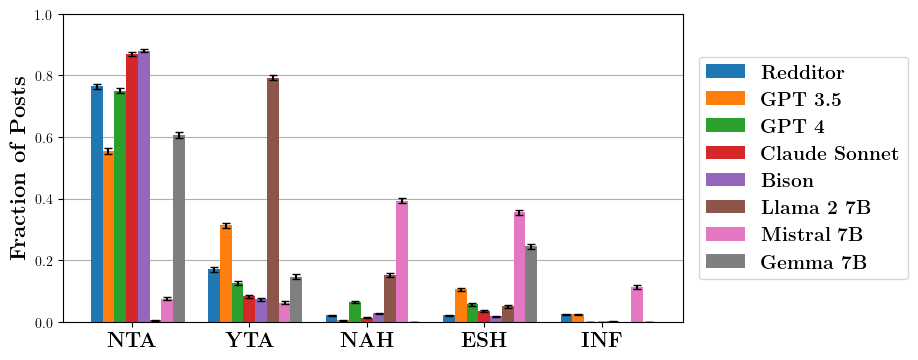

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

width = 0.1

# Iterate over model labels
for idx, reason_col in enumerate(keys.LABEL_COLS):
    # Calculate proportions
    proportions = df[reason_col].value_counts(normalize=True)
    # Fill in missing AITA labels
    for label in keys.AITA_LABELS:
        if label not in proportions:
            proportions[label] = 0
    # Sort AITA labels
    proportions = proportions.loc[keys.AITA_LABELS]

    # Plot fraction of posts for each AITA label
    ax.bar(
        x=np.arange(keys.n_aita_labels) + idx * width,
        height=proportions,
        width=width,
        color=f'C{idx}',
        yerr=[[observed_bounds[idx][ii].confidence_interval.high - proportions.loc[aita_label]
               for ii, aita_label in enumerate(keys.AITA_LABELS)],
              [proportions[aita_label] - observed_bounds[idx][ii].confidence_interval.low
               for ii, aita_label in enumerate(keys.AITA_LABELS)]],
        error_kw={'capsize': 3})
    

ax.set_xticks(np.arange(5) + 3 * width)
ax.set_xticklabels(bold_text(keys.AITA_LABELS_PLOT), fontsize=15)

for idx, label in enumerate(keys.MODEL_LABELS_PLOT):
    ax.bar(x=0.5, height=0, color=f'C{idx}', label=bold_text(label))

ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), prop={'size': 14})
    
ax.set_ylim([0, 1])
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_ylabel(bold_text('Fraction of Posts'), fontsize=16)
plt.savefig('label_distribution.pdf', bbox_inches='tight')